<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/using_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow as tf

from skimage import exposure

from google.colab import drive
from zipfile import ZipFile

from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Reshape
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(tf.__version__)

2.8.0


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path_out = '/content' #chemin dans l'env. colab ou on va copier les data de test supplementaires
path_drive = '/content/drive/MyDrive/kaggle'   # chemin de l'archive qui contient le fichier kaggle.json necessaire pour telecharger les donnees

#on telecharge les donnees depuis kaggle
if not os.path.exists('/content/kaggle'):
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
  os.mkdir(os.path.join(path_out, 'kaggle'))
  shutil.copy(os.path.join(path_drive, 'kaggle.json'), os.path.join(path_out, 'kaggle', 'kaggle.json'))

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

#on dezippe les donnees dans le repertoire path_out
archive = '/content/covid19-radiography-database.zip'
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)


NameError: ignored

In [ ]:
#Static data

cats = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
path_data = '/content/COVID-19_Radiography_Dataset'

IMG_SIZE = 299
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

val_size = 0.15
test_size = 0.15

contraste = ['equalized', 'initial']
poumon = ['image_initiale', 'poumon_only', 'poumon_cache']

#parametres du modele Lenet
n_filters = 8
dropout_rate = 0.2
n_dense = 2
n_units = 32

In [ ]:
# on cree les listes de chemins pours les images et les masques
# pour debugger/tester, on peut utiliser la variable N ci-dessous et decommenter les 3 lignes qui contiennent N
# ceci permet de generer des datasets qui contiennent uniquement N images par classes

# N=10

y = []
list_path_imgs = []
list_path_masks = []

for i in range(len(cats)):
  aux_imgs = sorted(
    [
        os.path.join(path_data, cats[i], 'images', fname)
        for fname in os.listdir(os.path.join(path_data, cats[i], 'images'))
        if fname.endswith(".png")
    ]
  )
  #list_path_imgs += aux_imgs[:N]
  list_path_imgs += aux_imgs

  aux_masks = sorted(
    [
        os.path.join(path_data, cats[i], 'masks', fname)
        for fname in os.listdir(os.path.join(path_data, cats[i], 'masks'))
        if fname.endswith(".png")
    ]
  )
  #list_path_masks += aux_masks[:N]
  list_path_masks += aux_masks

  if len(aux_masks) != len(aux_imgs):
    print("PB DANS LES DONNEES")
  
  #y+=[i]*len(aux_imgs[:N])
  y+=[i]*len(aux_imgs)
  print(len(list_path_imgs), len(list_path_masks))
  print(np.unique(y, return_counts=True))

3616 3616
(array([0]), array([3616]))
9628 9628
(array([0, 1]), array([3616, 6012]))
19820 19820
(array([0, 1, 2]), array([ 3616,  6012, 10192]))
21165 21165
(array([0, 1, 2, 3]), array([ 3616,  6012, 10192,  1345]))


In [ ]:
# on melange l'ensemble des donnees et on imprime les 10 premiers chemins pour verifier que lors du melange, on a bien respecte le triplet (image, mask, label)
list_path_imgs, list_path_masks, y = shuffle(list_path_imgs, list_path_masks, y)
list_path_imgs[:10], list_path_masks[:10], y[:10]

(['/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-779.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-9106.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-3230.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-4401.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-4605.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-7935.png',
  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-2746.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-47.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-4393.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-775.png'],
 ['/content/COVID-19_Radiography_Dataset/Lung_Opacity/masks/Lung_Opacity-779.png',
  '/content/COVID-19_Radiography_Dataset/Normal/masks/Normal-9106.png',
  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/mask

### pour debugger et reproduire la fonction preprocess sur une image

<class 'tensorflow.python.framework.ops.EagerTensor'> (299, 299, 1)
<class 'numpy.ndarray'> (299, 299, 1)
<class 'numpy.ndarray'> (299, 299) 0.0 1.0
<class 'numpy.ndarray'> (299, 299, 1) 0.0 1.0


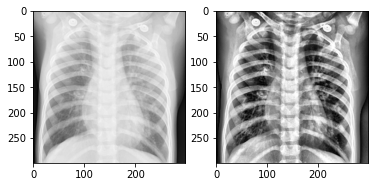

In [ ]:
img = tf.io.read_file(list_path_imgs[10])
img = tf.io.decode_png(img, channels=1)
img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='nearest')
print(type(img), img.shape)
array = img.numpy()
print(type(array), array.shape)
trans_img = exposure.equalize_adapthist(np.squeeze(array, -1), clip_limit=0.03)
print(type(trans_img), trans_img.shape, trans_img.min(), trans_img.max())
trans_img = np.expand_dims(trans_img, -1)
print(type(trans_img), trans_img.shape, trans_img.min(), trans_img.max())
plt.figure()
plt.subplot(121)
plt.imshow(np.squeeze(array), cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(trans_img), cmap='gray')

# On genere 6 jeux de données différentes

In [ ]:
# on genere 6 jeux de donnees differentes:
# contraste originales / images avec egalisation histo
# pour chacune de ces 2 categories, on teste 3 possibilites: poumons_only, poumons_retires, pas de masque

def preprocess (img_path, mask_path, contraste, poumon):  
  
  #on charge l'image originale
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='nearest')
  if contraste=='equalized':
    #on normalise les histogrammes et on ecrase l'image precedente
    array = np.squeeze(img.numpy(),-1)
    img = exposure.equalize_adapthist(array, clip_limit=0.03)
    #apres cette etape, l'image est de taille 299x299 et les pixels sont entre 0 et 1. On remet l'image au format attendu pour la suite des traitements (299,299,1) et pixels entre 0 et 255
    img = np.expand_dims(img, -1)
    img *= 255.
  if poumon =='image_initiale':
    return tf.cast(img, tf.float32)/255.0
  else:
    #on charge le masque
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
    if poumon=='poumon_only':
      masked_img = tf.bitwise.bitwise_and(img, mask)
    elif poumon=='poumon_cache':
      masked_img = tf.bitwise.bitwise_or(img, mask)
    else:
      print("probleme avec poumon")
      exit()
    return tf.cast(masked_img, tf.float32)/255.0
    
def preprocess1(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[0], poumon[0])

def preprocess2(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[0], poumon[1])
  
def preprocess3(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[0], poumon[2])

def preprocess4(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[1], poumon[0])

def preprocess5(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[1], poumon[1])
  
def preprocess6(img_path, mask_path):
  return preprocess(img_path, mask_path, contraste[1], poumon[2])


In [ ]:

n_test = int(test_size * len(list_path_imgs))
n_val = n_test + int(val_size * len(list_path_imgs))
print(n_test, n_val)

#on cree les datasets
test = tf.data.Dataset.from_tensor_slices((list_path_imgs[:n_test], list_path_masks[:n_test], y[:n_test]))
val = tf.data.Dataset.from_tensor_slices((list_path_imgs[n_test:n_val], list_path_masks[n_test:n_val], y[n_test:n_val]))
train = tf.data.Dataset.from_tensor_slices((list_path_imgs[n_val:], list_path_masks[n_val:], y[n_val:]))

train1 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess1, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val1 = val.map(lambda x, y, z: [tf.py_function(preprocess1, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test1 = test.map(lambda x, y, z: [tf.py_function(preprocess1, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train2 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess2, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val2 = val.map(lambda x, y, z: [tf.py_function(preprocess2, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test2 = test.map(lambda x, y, z: [tf.py_function(preprocess2, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train3 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess3, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val3 = val.map(lambda x, y, z: [tf.py_function(preprocess3, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test3 = test.map(lambda x, y, z: [tf.py_function(preprocess3, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train4 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess4, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val4 = val.map(lambda x, y, z: [tf.py_function(preprocess4, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test4 = test.map(lambda x, y, z: [tf.py_function(preprocess4, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train5 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess5, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val5 = val.map(lambda x, y, z: [tf.py_function(preprocess5, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test5 = test.map(lambda x, y, z: [tf.py_function(preprocess5, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

train6 = train.shuffle(15000).map(lambda x, y, z: [tf.py_function(preprocess6, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
val6 = val.map(lambda x, y, z: [tf.py_function(preprocess6, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)
test6 = test.map(lambda x, y, z: [tf.py_function(preprocess6, [x, y], [tf.float32]), z], num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)


3174 6348


In [ ]:
#on va verifier la repartion des classes dans chaque ensemble
print('pour test:',np.unique(y[:n_test], return_counts=True))
print('pour val:',np.unique(y[n_test:n_val], return_counts=True))
_, ndata = np.unique(y[n_val:], return_counts=True)
weights = [ndata.max()/n for n in ndata]
print('pour train:',ndata)
print(weights)
class_weights = {}
for i in range(len(cats)):
  class_weights[i] = weights[i]

pour test: (array([0, 1, 2, 3]), array([ 528,  930, 1532,  184]))
pour val: (array([0, 1, 2, 3]), array([ 551,  877, 1533,  213]))
pour train: [2537 4205 7127  948]
[2.8092234923137562, 1.6948870392390012, 1.0, 7.517932489451477]


In [ ]:
_, data_test = np.unique(y[:n_test], return_counts=True)
print("dans l'echantillon de test, on a donc les proportions suivantes: \n",[n/np.sum(data_test) for n in data_test])

dans l'echantillon de test, on a donc les proportions suivantes: 
 [0.166351606805293, 0.29300567107750475, 0.48267170762444866, 0.057971014492753624]


(64, 1, 299, 299, 1)
(64, 1, 299, 299, 1)
(64, 1, 299, 299, 1)
(64, 1, 299, 299, 1)
(64, 1, 299, 299, 1)
(64, 1, 299, 299, 1)


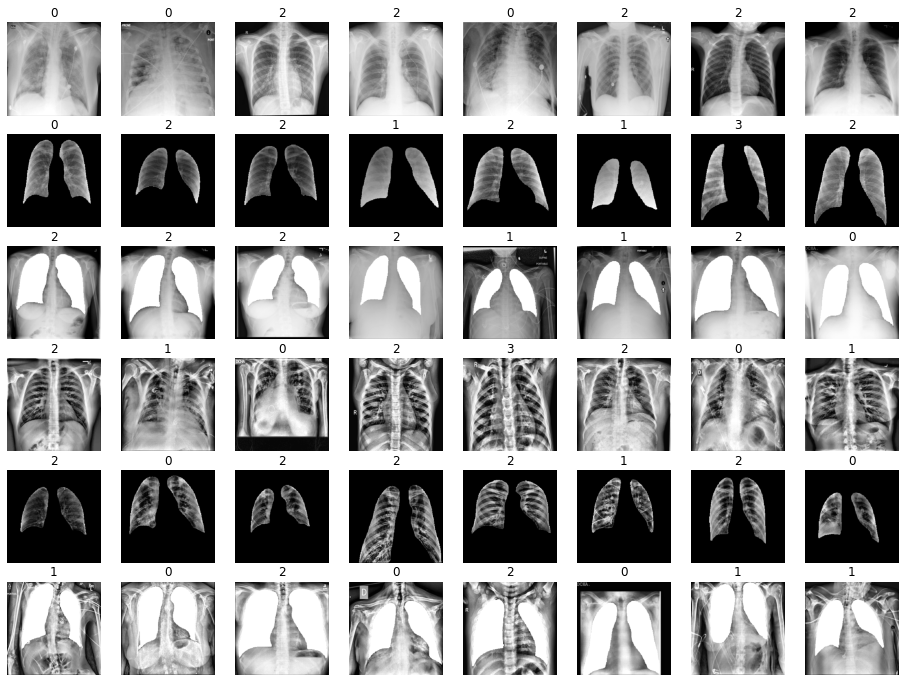

In [ ]:
#on regarde les 8 premieres images/labels du premier batch d'entrainement pour verifier

trains = [train1, train2, train3, train4, train5, train6]
vals = [val1, val2, val3, val4, val5, val6]
tests = [test1, test2, test3, test4, test5, test6]

plt.figure(figsize=(16,12))
for i, train in enumerate(trains):
  imgs, labels = next(iter(train))
  print(imgs.shape)
  for j in range(8):
    plt.subplot(6,8,8*i+j+1)
    plt.imshow(np.squeeze(imgs[j].numpy()), cmap='gray')
    plt.title(labels.numpy()[j])
    plt.axis('off')

In [ ]:
# fonction qui construit le modele Lenet

def build_model_LeNet(n_filters=32, dropout_rate=0.5, n_dense=1, n_units=128, summary=False):
    LeNet = Sequential()
    #pour une raison que j'ignore, le batch ajoute une dimension avant l'image. On modifie donc la taille de l'input et on ajoute une couche de redimensionnement qui elimine cette dimension superflue
    LeNet.add(Input(shape = [1, IMG_SIZE, IMG_SIZE,1]))
    LeNet.add(Reshape([IMG_SIZE, IMG_SIZE,1]))
    LeNet.add(Conv2D(filters=n_filters, kernel_size=(5,5), activation='relu', padding='valid'))
    LeNet.add(MaxPooling2D(pool_size=(2,2)))
    LeNet.add(Conv2D(filters=n_filters*2, kernel_size=(3,3), activation='relu', padding='valid'))
    LeNet.add(MaxPooling2D(pool_size=(2,2)))
    LeNet.add(Conv2D(filters=n_filters*4, kernel_size=(3,3), activation='relu', padding='valid'))
    LeNet.add(MaxPooling2D(pool_size=(2,2)))
    LeNet.add(Dropout(rate=dropout_rate))
    LeNet.add(Flatten())
    for i in range(n_dense):
        LeNet.add(Dense(units=n_units, activation='relu'))
    LeNet.add(Dense(units = 4, activation='softmax'))

    if summary:
        LeNet.summary()
        
    LeNet.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(LeNet)

In [ ]:
# fonction qui enregistre les resultats et les sauve dans un fichier 
def save_config_and_model_results(n_filters, dropout_rate, n_dense, n_units, train_hist, class_report, confusion_matrix, contraste, poumon, name):
  res = {}
  res['date'] = str(datetime.datetime.today()).split()[0]
  res['contraste'] = contraste
  res['pumon'] = poumon
  res['hist'] = train_hist.history
  res['cr'] = class_report
  res['confusion_matrix'] = confusion_matrix
  res['n_filters'] = n_filters
  res['drop_out'] = dropout_rate
  res['n_dense'] = n_dense
  res['n_units'] = n_units
  np.save(name, res)

In [ ]:
# on definit une fonction qui prend en input une liste de configurations (parmi les 6 jeux de donnees crees) et qui va:
# entrainer le modele et sauver les courbes d'apprentissage
# calculer les predictions sur l'echantillon de test apres l'entrainement
# calculer un classification report et une matrice de confusion

es = EarlyStopping(monitor="val_loss",
                   patience=6,
                   restore_best_weights=True, 
                   verbose=1)

red_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.5, 
                           patience=2, 
                           verbose=1)

def train_models(poumons, contrastes, trains, vals, tests):
  i=0
  for p, c, train, val, test in zip(poumons, contrastes, trains, vals, tests):
    print('-------------------------------------------------------')
    print('poumon: {}, contraste: {}'.format(p, c))
    print('-------------------------------------------------------')
    save_name = 'Lenet_'+p+'_'+c
    mod = build_model_LeNet(n_filters, dropout_rate, n_dense, n_units, summary=False)
    checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/'+save_name, monitor='val_loss', save_best_only=True, verbose=1)
    hist = mod.fit(train, epochs=16, batch_size=BATCH_SIZE, validation_data=val, class_weight= class_weights, callbacks=[es, red_lr, checkpoint])
    y_pred_probas = mod.predict(test)
    y_pred = tf.argmax(y_pred_probas, -1).numpy()
    y_test = y[:n_test]
    cr = classification_report(y_test, y_pred)
    print('Classification Report')
    print(cr)
    cm = pd.crosstab(np.array(y_test), y_pred, rownames=['realite'], colnames=['prediction'])
    print('Confusion Matrix')
    print(cm)
    save_config_and_model_results(n_filters, dropout_rate, n_dense, n_units, hist, cr, cm, c, p, '/content/drive/MyDrive/Colab Notebooks/covid/results/'+save_name+'.npy')
    i += 1

# Code pour reprendre l'entrainement des modeles qui ont ete interrompus

In [ ]:
# on reprend l'entrainement du modele 6 qui s'est arrete en plein milieu
name_model = 'Lenet_'+poumon[2]+'_'+contraste[1]
mod = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/'+name_model)
hist = mod.fit(train5, epochs=16, batch_size=BATCH_SIZE, validation_data=val5, class_weight= class_weights, callbacks=[es, red_lr, checkpoint])
y_pred_probas = mod.predict(test5)
y_pred = tf.argmax(y_pred_probas, -1).numpy()
y_test = y[:n_test]
cr = classification_report(y_test, y_pred)
print('Classification Report')
print(cr)
cm = pd.crosstab(np.array(y_test), y_pred, rownames=['realite'], colnames=['prediction'])
print('Confusion Matrix')
print(cm)
save_config_and_model_results(n_filters, dropout_rate, n_dense, n_units, hist, cr, cm, contraste[1], poumon[1], '/content/drive/MyDrive/Colab Notebooks/covid/results/'+name_model+'.npy')


# boucle pour entrainer les 6 modeles d'un coup. Attention, les 3 derniers modeles avec histogrammes normalises mettent 4h30 a s'entrainer...

In [ ]:
trains = [train1, train2, train3, train4, train5, train6]
vals = [val1, val2, val3, val4, val5, val6]
tests = [test1, test2, test3, test4, test5, test6]
poumons = [poumon[0], poumon[1], poumon[2], poumon[0], poumon[1], poumon[2]]
contrastes = [contraste[0], contraste[0], contraste[0], contraste[1], contraste[1], contraste[1]]

# Colab m'a deconnecte en plein calcul, on relance les 3 derniers jeux de test, cela prend environ 4h30 en GPU (400s par epoch...)
# il aurait ete plus rapide de construire une seule fois un jeu de donnees aux bons formats et d'appeler le modele (sans pretraitement autre que /255.) sur ces differents jeux de donnees
# car dans notre implementation, il reconstruit toutes les images a chaque epoch.

#trains = [train4, train5, train6]
#vals = [val4, val5, val6]
#tests = [test4, test5, test6]
#poumons = [poumon[0], poumon[1], poumon[2]]
#contrastes = [contraste[1], contraste[1], contraste[1]]

train_models(poumons, contrastes, trains, vals, tests)

-------------------------------------------------------
poumon: image_initiale, contraste: equalized
-------------------------------------------------------
Epoch 1/16
232/232 [==============================] - ETA: 0s - loss: 1.6487 - accuracy: 0.6012
Epoch 1: val_loss improved from inf to 0.64856, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_image_initiale_equalized
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_image_initiale_equalized/assets
232/232 [==============================] - 343s 1s/step - loss: 1.6487 - accuracy: 0.6012 - val_loss: 0.6486 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 2/16
232/232 [==============================] - ETA: 0s - loss: 0.9619 - accuracy: 0.7624
Epoch 2: val_loss improved from 0.64856 to 0.60458, saving model to /content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_image_initiale_equalized
INFO:tensorflow:Assets written to: /conte

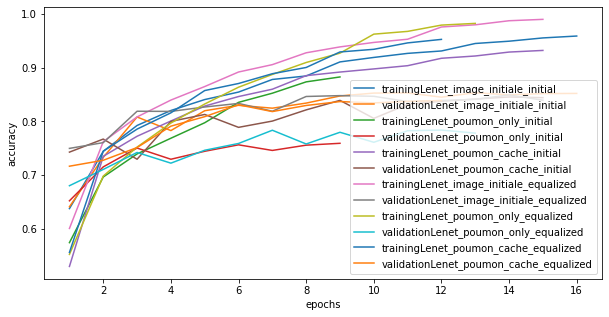

In [ ]:
#on va verifier l'enregistrement des resultats
path = '/content/drive/MyDrive/Colab Notebooks/covid/results/' 
names =  ['Lenet_'+poumon[i%3]+'_'+contraste[i//3] for i in range(6)]
path_res = [path+name+'.npy' for name in names]
liste_res = {}
fig = plt.figure(figsize=(10,5))
for name, mod in zip(names, path_res):
  liste_res[name] = np.load(mod, allow_pickle='TRUE').item()
  hist = liste_res[name]['hist']
  #print(hist['accuracy'])
  #print (liste_res[name]['cr'])
  #print (liste_res[name]['confusion_matrix'])
  epochs = len(hist['accuracy'])
  plt.plot(np.arange(1,epochs+1,1), hist['accuracy'], label='training'+name)
  plt.plot(np.arange(1,epochs+1,1), hist['val_accuracy'], label='validation'+name)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
    

# on affiche les resultats

## courbes d'entrainement pour chaque jeu de donnees

In [ ]:
path

'/content/drive/MyDrive/Colab Notebooks/covid/results/'

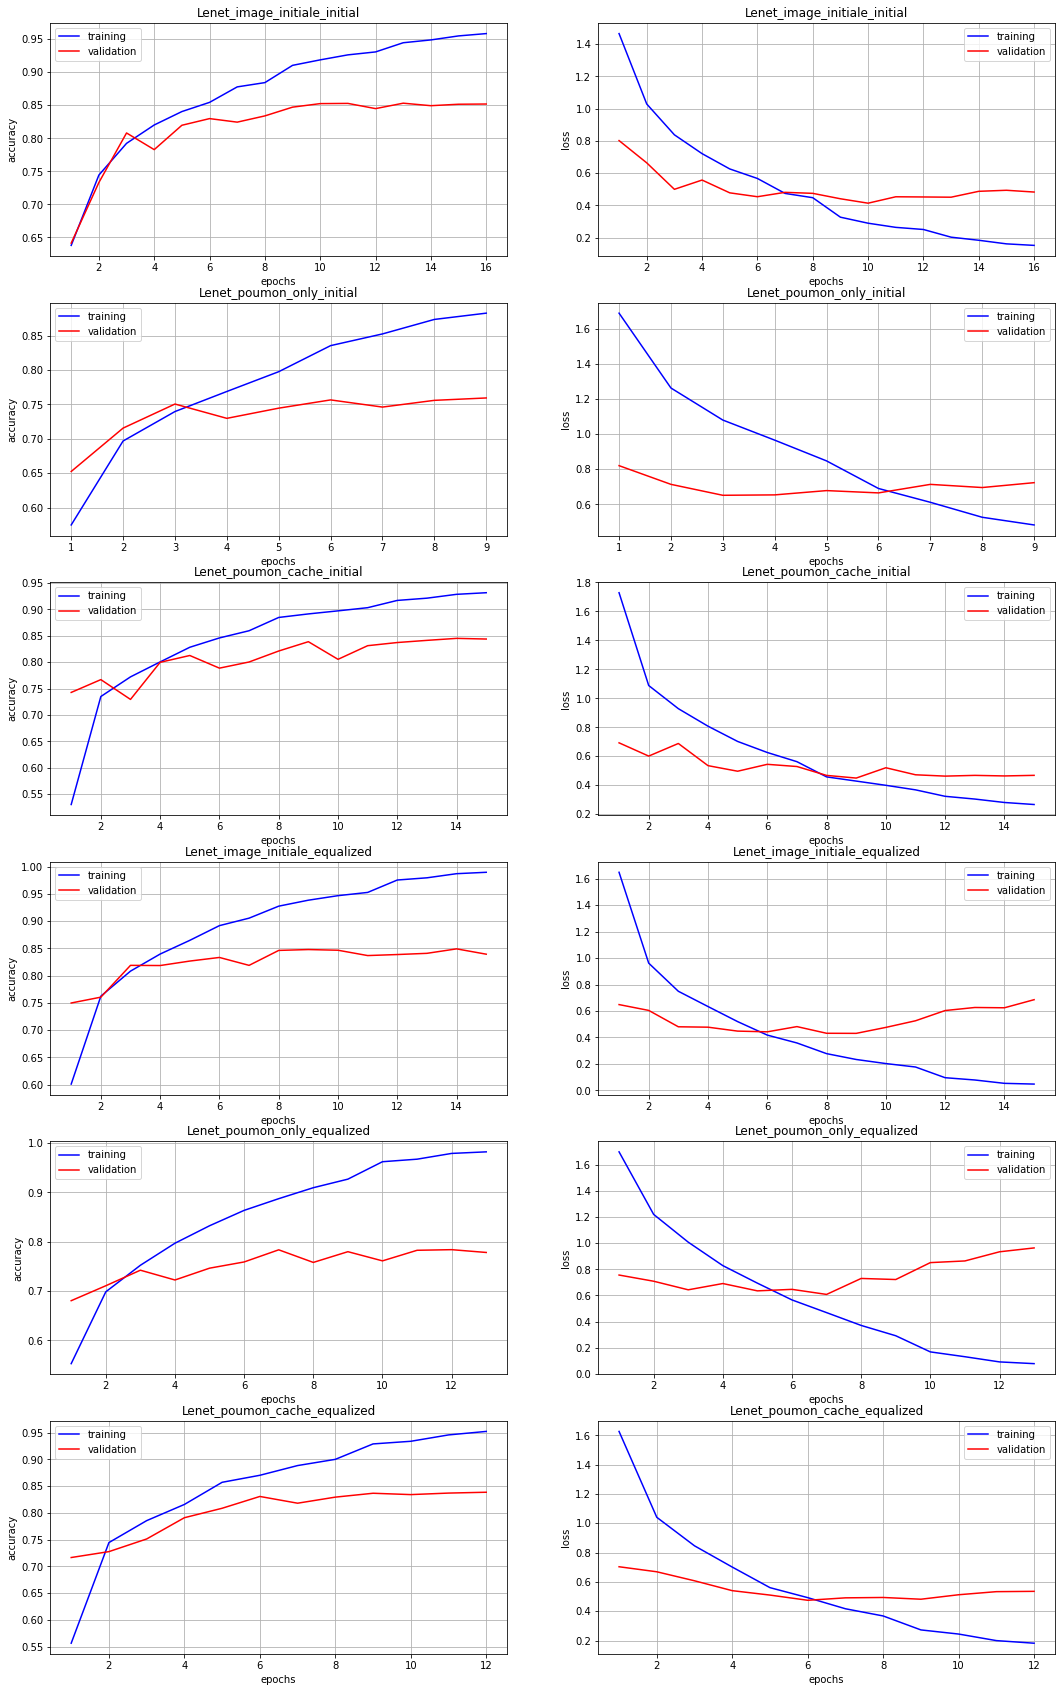

In [ ]:
n_mods = len(names)
fig, axs = plt.subplots(n_mods, 2, figsize=(18,30))

for row in range(len(names)):
  hist = liste_res[names[row]]['hist']
  epochs = len(hist['accuracy'])
  axs[row, 0].plot(np.arange(1,epochs+1,1), hist['accuracy'], 'blue', label='training')
  axs[row, 0].plot(np.arange(1,epochs+1,1), hist['val_accuracy'], 'r', label='validation')
  axs[row, 0].set_xlabel('epochs')
  axs[row, 0].set_ylabel('accuracy')
  axs[row, 0].legend()
  axs[row, 0].grid()
  axs[row, 0].set_title(names[row])
  
  axs[row, 1].plot(np.arange(1,epochs+1,1), hist['loss'], 'blue', label='training')
  axs[row, 1].plot(np.arange(1,epochs+1,1), hist['val_loss'], 'r', label='validation')
  axs[row, 1].set_xlabel('epochs')
  axs[row, 1].set_ylabel('loss')
  axs[row, 1].legend()
  axs[row, 1].grid()
  axs[row, 1].set_title(names[row])

fig.savefig(path+'_compare_convergence_poumon_contraste_lenet.png')

## classification report calcule sur les ensemble de test

In [ ]:
# pour imprimer en gras et/ou en couleur
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   
for name in names:
  cr = liste_res[name]['cr']
  print("Accuracy on test data for modele "+color.BOLD+str(name)+color.END+" is "+color.BOLD+color.RED+str(cr.split()[25])+color.END)
  #print("Accuracy on test data for modele: {} is {}".format(name, cr.split()[25]))
  print(cr)

Accuracy on test data for modele Lenet_image_initiale_initial is 0.85
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       528
           1       0.81      0.78      0.79       931
           2       0.86      0.89      0.88      1518
           3       0.91      0.92      0.92       197

    accuracy                           0.85      3174
   macro avg       0.86      0.86      0.86      3174
weighted avg       0.85      0.85      0.85      3174

Accuracy on test data for modele Lenet_poumon_only_initial is 0.75
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       528
           1       0.78      0.67      0.72       931
           2       0.83      0.83      0.83      1518
           3       0.74      0.95      0.83       197

    accuracy                           0.75      3174
   macro avg       0.71      0.76      0.73      3174
weighted avg       0.76      0.75      0.75     

## matrice de confusion sur les ensemble de test

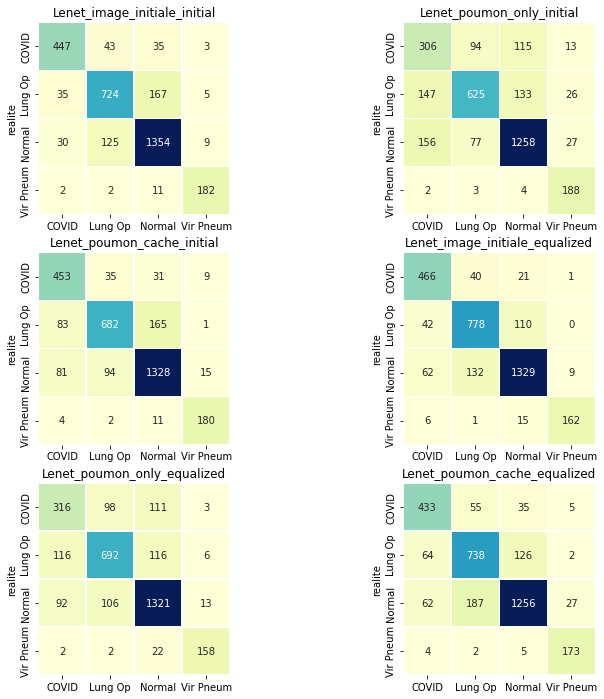

In [ ]:
import seaborn as sns

n_rows = 3
n_cols = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))
d = {0: 'COVID', 1: 'Lung Op', 2: 'Normal', 3: 'Vir Pneum'}
for i in range(n_mods):
  z = liste_res[names[i]]['confusion_matrix']
  z.columns=d.values()
  z = z.reset_index()
  z['realite'] = z['realite'].replace(d)
  z = z.set_index('realite')
  g = sns.heatmap(data=z, cbar = False, cmap="YlGnBu", fmt='d', linewidths=.5, square=True, annot=True, ax=axs[i//n_cols, i -n_cols*(i//n_cols)])
  g.set_title(str(names[i]));

fig.savefig(path+'compare_conf_matrix_poumon_contraste_lenet.png')